## First attempt at ML over the graph output - Richard Henderson -  (c) TigerGraph 2020
Intended to show how ML is cheaper/faster/better with graph feeding it

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import ipywidgets as widgets
widgets.IntSlider() # this just checks that widgets is working, should be a slider

IntSlider(value=0)

In [6]:
data_df = pd.read_csv('./outall-30days.csv') # file generated by graph query

In [7]:
# Data is unbalanced as we'd expect, many fewer frauds than good transactions
data_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

In [8]:
# what the big data looks like, notice the graph generated features on the right
# These are generated on the fly
data_df

id  amount  fraud  step         cust        merch  \
0         8144    6.85      0     3   C394979408   M348934600   
1         8115   12.97      0     3  C2094478222   M348934600   
2         8110    0.59      0     3  C1735726583   M348934600   
3         8104   61.84      0     3  C2072009750   M348934600   
4         8033    5.90      0     3  C1867965524   M151143676   
...        ...     ...    ...   ...          ...          ...   
594638  570930   30.29      0   173    C20239039  M1823072687   
594639  570919   12.83      0   173  C1080719046  M1823072687   
594640  577340   13.13      0   175  C2005297705  M1823072687   
594641  576306   43.00      0   175   C707234445  M1823072687   
594642  576402    4.42      0   175  C1704116821  M1823072687   

                          cat  cust_sum  cust_max  cust_num_t  cust_num_f  \
0           es_transportation     91.53     44.62           4           0   
1           es_transportation    215.65    123.17           4           0   
2           es_transportation     99.20     49.55           4           0   
3           es_transportation    125.17     61.84           3           0   
4       es_barsandrestaurants    148.29     59.83           4           0   
...                       ...       ...       ...         ...         ...   
594638      es_transportation    814.40     63.22          29           0   
594639      es_transportation    688.42     60.36          29           0   
594640      es_transportation    710.82     51.31          30           0   
594641      es_transportation    909.32    232.96          29           0   
594642      es_transportation    846.32    104.17          32           0   

         merch_sum  merch_max  merch_num_t  merch_num_f     cat_sum  cat_max  \
0        176730.00     106.16         6542            0   223037.00   106.16   
1        176730.00     106.16         6542            0   223037.00   106.16   
2        176730.00     106.16         6542            0   223037.00   106.16   
3        176730.00     106.16         6542            0   223037.00   106.16   
4          8716.53     195.81          200            2     8716.53   195.81   
...            ...        ...          ...          ...         ...      ...   
594638  1971960.00     110.93        72867            0  2624290.00   110.93   
594639  1971960.00     110.93        72867            0  2624290.00   110.93   
594640  1980990.00     110.93        73219            0  2626620.00   110.93   
594641  1980990.00     110.93        73219            0  2626620.00   110.93   
594642  1980990.00     110.93        73219            0  2626620.00   110.93   

        cat_num_t  cat_num_f  
0            8259          0  
1            8259          0  
2            8259          0  
3            8259          0  
4             200          2  
...           ...        ...  
594638      97140          0  
594639      97140          0  
594640      97237          0  
594641      97237          0  
594642      97237          0  

[594643 rows x 19 columns]

In [34]:
data_df.dtypes

id               int64
amount         float64
fraud            int64
step             int64
cust            object
merch           object
cat             object
cust_sum       float64
cust_max       float64
cust_num_t       int64
cust_num_f       int64
merch_sum      float64
merch_max      float64
merch_num_t      int64
merch_num_f      int64
cat_sum        float64
cat_max        float64
cat_num_t        int64
cat_num_f        int64
dtype: object

In [36]:
# hmm, problem is that fraud is seen as a value, when it should be a category where 0=not fraud, and 1= fraud
cat_type = pd.CategoricalDtype(categories=[0,1])
data_df['fraud'] = data_df['fraud'].astype(cat_type)

In [37]:
data_df.dtypes

id                int64
amount          float64
fraud          category
step              int64
cust             object
merch            object
cat              object
cust_sum        float64
cust_max        float64
cust_num_t        int64
cust_num_f        int64
merch_sum       float64
merch_max       float64
merch_num_t       int64
merch_num_f       int64
cat_sum         float64
cat_max         float64
cat_num_t         int64
cat_num_f         int64
dtype: object

### We need to run a reasonable ML such that we can score any subsequent set.
### We'll split the data-set into the relational one by selecting out only the relevant columns from the full width graph one

In [63]:
# Define the columns we care about, notice we don't want step!
target='fraud'
rdb_predictors=['amount','cust','merch','cat']
graph_predictors =['amount','cust','merch','cat',
    'cust_sum','cust_max','cust_num_t','cust_num_f',
    'merch_sum','merch_max','merch_num_t','merch_num_f',
    'cat_sum','cat_max','cat_num_t','cat_num_f']

In [64]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True )

In [65]:
X_relational=data_df[rdb_predictors]
X_relational.dtypes

amount    float64
cust       object
merch      object
cat        object
dtype: object

In [93]:
# let's check the score of a dumb classifer: everything is not fraud
from sklearn import metrics
l=pd.DataFrame(valid_df['fraud']) # extract only the fraud column
l['baseline'] =0 # add a column which is always 0 (not fraud), this will be our prediction
l['baseline'] = l['baseline'].astype(cat_type)

Let's measure our dumb classifier
This is our standard way of seeing whether we are winning
1) No need for feature importance (duh, nothing is important here)
2) We'll do a confusion matrix (telling us how many positives, false positives, negatives, false negatives)
3) Score using balanced accuracy score (supposed to be good for unbalanced data)
4) 

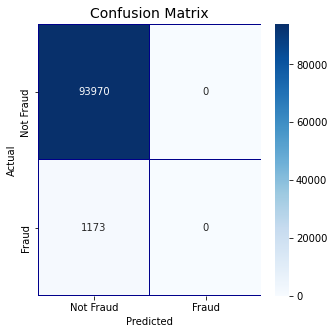

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = pd.crosstab(l[target], l['baseline'], rownames=['Actual'], colnames=['Predicted'], dropna=False)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, 
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [68]:
# We can see above, no frauds are predicted. Bottom left is the problem! Top right would be a problem too.
# On to the real modelling!

In [69]:
# 
from catboost import CatBoostClassifier

clf = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=20, od_wait=25) 

In [70]:
# grab the non-numeric features
categorical_features_indices = np.where(train_df[rdb_predictors].dtypes != np.float)[0]
categorical_features_indices

array([1, 2, 3])

In [71]:
rdb_model = clf.fit(train_df[rdb_predictors], train_df[target],cat_features=categorical_features_indices,eval_set=(test_df[rdb_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.137492
0:	learn: 0.8457555	test: 0.8298852	best: 0.8298852 (0)	total: 104ms	remaining: 1m 43s


20:	learn: 0.8962130	test: 0.8895872	best: 0.8902598 (19)	total: 1.64s	remaining: 1m 16s
40:	learn: 0.9053721	test: 0.8981398	best: 0.8981398 (40)	total: 2.96s	remaining: 1m 9s
60:	learn: 0.9099669	test: 0.9005535	best: 0.9008984 (58)	total: 4.2s	remaining: 1m 4s
80:	learn: 0.9144671	test: 0.9015923	best: 0.9026183 (77)	total: 5.44s	remaining: 1m 1s
100:	learn: 0.9146016	test: 0.9012389	best: 0.9026183 (77)	total: 6.81s	remaining: 1m
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9026182552
bestIteration = 77

Shrink model to first 78 iterations.


In [122]:
# So now we need to test the model against the validator
preds = clf.predict(valid_df[rdb_predictors]) 

Predicted      0  1
Actual             
0          93970  0
1           1173  0
Predicted      0    1
Actual               
0          93890   80
1            227  946


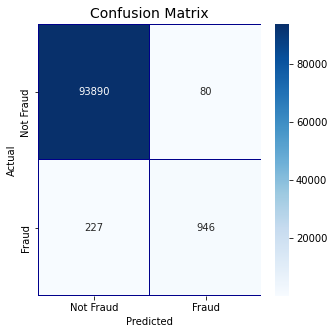

In [127]:
# Lets see how the relational predictor works. Score looks better
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
print(cm1)
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
ax1 = sns.heatmap(cm1, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

So compared to dumb one, now we've predicted 946 frauds with 80 false positives. Previously we had zero false positives.
We've also let 227 frauds go through as not frauds, previously we let 1173 (all the frauds) go through as not-frauds
On to the graph version.

Let's see what was the most significant factors:

In [128]:
tmp = pd.DataFrame({'Feature': rdb_predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [133]:
# grab the non-numeric features
categorical_features_indices = np.where(train_df[graph_predictors].dtypes != np.float)[0]

In [134]:
# Lets make a new model, to avoid overlaps, exactly the same parameters
clf2 = CatBoostClassifier(eval_metric='BalancedAccuracy', od_type='Iter', metric_period=20, od_wait=25) 

In [135]:
clf2.fit(train_df[graph_predictors], train_df[target],cat_features=categorical_features_indices,eval_set=(test_df[graph_predictors], test_df[target]),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.137492


0:	learn: 0.8163398	test: 0.8044871	best: 0.8044871 (0)	total: 203ms	remaining: 3m 23s
20:	learn: 0.9599848	test: 0.9573010	best: 0.9573010 (20)	total: 3.97s	remaining: 3m 5s
40:	learn: 0.9660224	test: 0.9624650	best: 0.9628098 (38)	total: 8.6s	remaining: 3m 21s
60:	learn: 0.9681379	test: 0.9648490	best: 0.9662368 (56)	total: 13.8s	remaining: 3m 33s
80:	learn: 0.9707863	test: 0.9658834	best: 0.9665901 (65)	total: 18.6s	remaining: 3m 30s
100:	learn: 0.9732202	test: 0.9665859	best: 0.9676161 (86)	total: 23.3s	remaining: 3m 27s
120:	learn: 0.9748801	test: 0.9679567	best: 0.9679609 (103)	total: 28.3s	remaining: 3m 25s
140:	learn: 0.9763109	test: 0.9683100	best: 0.9689911 (125)	total: 33.2s	remaining: 3m 21s
160:	learn: 0.9775298	test: 0.9682845	best: 0.9689997 (149)	total: 37.9s	remaining: 3m 17s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.968999651
bestIteration = 149

Shrink model to first 150 iterations.


In [137]:
# So now we need to test the model against the validator
preds = clf.predict(valid_df[graph_predictors]) 

Predicted      0  1
Actual             
0          93970  0
1           1173  0
Predicted      0    1
Actual               
0          93890   80
1            227  946
Predicted      0     1
Actual                
0          93924    46
1             79  1094


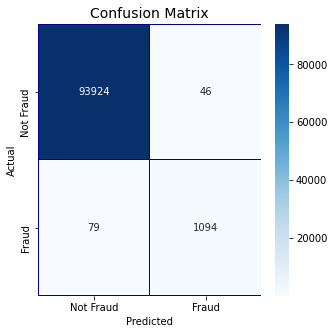

In [138]:
# Lets see how the graph predictor works. Score looks much better
import matplotlib.pyplot as plt
import seaborn as sns
cm2 = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'], dropna=False)
print (cm)
print(cm1)
print(cm2)
fig, (ax2) = plt.subplots(ncols=1, figsize=(5,5))
ax2 = sns.heatmap(cm2, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt="d")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

So now we see a further improvement over the simple relational case:
We've increased real frauds found from 946 to 1094, that is +148 frauds, that is a 15% improvement in fraud interception.
We've reduced our missed frauds from 227 to 79, that is a 35% improvement.
We've increased our good transactions from 93890 to 93924, which is good, but I won't double count this :).
We've reduced our false positives, possibly the most costly issue, from 80 to 46. That's a 42.5% reduction in incorrectly rejected transactions.

Why is this better?:

We can see the most important feaure is whether a customer has had previous frauds, followed by the value of historical frauds on a merchant, and then the number of frauds on a merchant. These are all graph generated contextual features. Note the explainability here.

In [136]:
tmp = pd.DataFrame({'Feature': graph_predictors, 'Feature importance': clf2.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The question arises, could these features have been generated in a relational store? 
The answer here is a "yes, but why would you do that"?
Specifically, agregating transactions in real-time is expensive and slow as it needs to do a read before a write.
Furthermore, as the model improves, different aggregates may be needed, requiring a schema change. With graph this simply isn't needed. We calculate the aggregates at query time faster than they can be read from disk.
Finally, in TigerGraph, the specific model can be run within the database itself, meaning scoring can be integrated with the graph, providing real-time scoring, as well as providing a means to include simple rules (like immediately shutting down a card if it has a suspected fraud).